Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score,
                             mean_absolute_error, root_mean_squared_error, r2_score,
                             classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, joblib
warnings.filterwarnings('ignore')

Загрузка и предобработка данных

In [5]:

df_burnout = pd.read_csv('data/employee_burnout.csv')

X_clf = df_burnout.drop(['Burnout', 'Name'], axis=1)
y_clf = df_burnout['Burnout']

categorical_features_clf = ['Gender', 'JobRole']
numeric_features_clf = [col for col in X_clf.columns if col not in categorical_features_clf]

preprocessor_clf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_clf),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_clf)
    ])

df_sales = pd.read_csv('data/walmart_sales.csv')
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d-%m-%Y')
df_sales = df_sales.sort_values('Date')

X_reg = df_sales.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg = df_sales['Weekly_Sales']

categorical_features_reg = ['Store', 'Holiday_Flag']
numeric_features_reg = [col for col in X_reg.columns if col not in categorical_features_reg]

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_reg),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_reg)
    ])

Создание и обучение бейзлайна

In [21]:
rf_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_estimators=100, 
        class_weight='balanced' 
    ))
])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=27, stratify=y_clf
)

print("\nОбучение RandomForestClassifier...")
rf_clf.fit(X_train_clf, y_train_clf)
print("RandomForestClassifier обучен")

rf_reg = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('regressor', RandomForestRegressor(
        random_state=42,
        n_estimators=100
    ))
])

split_idx = int(len(df_sales) * 0.7)
X_train_reg, X_test_reg = X_reg.iloc[:split_idx], X_reg.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

print("\nОбучение RandomForestRegressor...")
rf_reg.fit(X_train_reg, y_train_reg)
print("RandomForestRegressor обучен")


Обучение RandomForestClassifier...
RandomForestClassifier обучен

Обучение RandomForestRegressor...
RandomForestRegressor обучен


Оценка качества RandomForestClassifier

In [22]:

y_pred_clf = rf_clf.predict(X_test_clf)
y_proba_clf = rf_clf.predict_proba(X_test_clf)[:, 1]

clf_recall = recall_score(y_test_clf, y_pred_clf)
clf_precision = precision_score(y_test_clf, y_pred_clf)
clf_f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
clf_rocauc = roc_auc_score(y_test_clf, y_proba_clf)

print(f"Recall (класс 1): {clf_recall:.4f}")
print(f"Precision (класс 1): {clf_precision:.4f}")
print(f"F1-score (weighted): {clf_f1:.4f}")
print(f"ROC-AUC: {clf_rocauc:.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test_clf, y_pred_clf))

print("\nДетальный отчет:")
print(classification_report(y_test_clf, y_pred_clf))

feature_names = (numeric_features_clf + 
                 list(rf_clf.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features_clf)))
importances_clf = rf_clf.named_steps['classifier'].feature_importances_
indices_clf = np.argsort(importances_clf)[::-1][:10]

print("\nTop-10 важных признаков:")
for i, idx in enumerate(indices_clf):
    print(f"{i+1}. {feature_names[idx]}: {importances_clf[idx]:.4f}")

Recall (класс 1): 0.9487
Precision (класс 1): 1.0000
F1-score (weighted): 0.9966
ROC-AUC: 1.0000

Матрица ошибок:
[[561   0]
 [  2  37]]

Детальный отчет:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       561
           1       1.00      0.95      0.97        39

    accuracy                           1.00       600
   macro avg       1.00      0.97      0.99       600
weighted avg       1.00      1.00      1.00       600


Top-10 важных признаков:
1. StressLevel: 0.4122
2. WorkHoursPerWeek: 0.2679
3. SatisfactionLevel: 0.2483
4. RemoteRatio: 0.0257
5. Age: 0.0181
6. Experience: 0.0180
7. JobRole_HR: 0.0024
8. Gender_Male: 0.0022
9. JobRole_Manager: 0.0021
10. JobRole_Sales: 0.0016


Оценка качества RandomForestRegressor

In [23]:
y_pred_reg = rf_reg.predict(X_test_reg)

reg_mae = mean_absolute_error(y_test_reg, y_pred_reg)
reg_rmse = root_mean_squared_error(y_test_reg, y_pred_reg)
reg_r2 = r2_score(y_test_reg, y_pred_reg)

print(f"MAE: ${reg_mae:,.2f}")
print(f"RMSE: ${reg_rmse:,.2f}")
print(f"R²: {reg_r2:.4f}")

feature_names_reg = (numeric_features_reg + 
                     list(rf_reg.named_steps['preprocessor']
                          .named_transformers_['cat']
                          .get_feature_names_out(categorical_features_reg)))
importances_reg = rf_reg.named_steps['regressor'].feature_importances_
indices_reg = np.argsort(importances_reg)[::-1][:10]

print("\nTop-10 важных признаков:")
for i, idx in enumerate(indices_reg):
    print(f"{i+1}. {feature_names_reg[idx]}: {importances_reg[idx]:.4f}")

rf_clf_model = rf_clf.named_steps['classifier']
rf_reg_model = rf_reg.named_steps['regressor']

print(f"\nСлучайный лес (классификация):")
print(f"  Количество деревьев: {len(rf_clf_model.estimators_)}")
print(f"  Средняя глубина деревьев: {np.mean([tree.get_depth() for tree in rf_clf_model.estimators_]):.2f}")
print(f"  Среднее количество листьев: {np.mean([tree.get_n_leaves() for tree in rf_clf_model.estimators_]):.2f}")

print(f"\nСлучайный лес (регрессия):")
print(f"  Количество деревьев: {len(rf_reg_model.estimators_)}")
print(f"  Средняя глубина деревьев: {np.mean([tree.get_depth() for tree in rf_reg_model.estimators_]):.2f}")
print(f"  Среднее количество листьев: {np.mean([tree.get_n_leaves() for tree in rf_reg_model.estimators_]):.2f}")

MAE: $236,555.21
RMSE: $312,073.62
R²: 0.6622

Top-10 важных признаков:
1. Store_14: 0.0805
2. Store_20: 0.0802
3. Store_4: 0.0763
4. Store_13: 0.0728
5. Store_2: 0.0683
6. Store_10: 0.0678
7. CPI: 0.0614
8. Store_27: 0.0578
9. Store_6: 0.0327
10. Temperature: 0.0300

Случайный лес (классификация):
  Количество деревьев: 100
  Средняя глубина деревьев: 9.63
  Среднее количество листьев: 27.25

Случайный лес (регрессия):
  Количество деревьев: 100
  Средняя глубина деревьев: 50.39
  Среднее количество листьев: 2847.30


Визуализация результатов


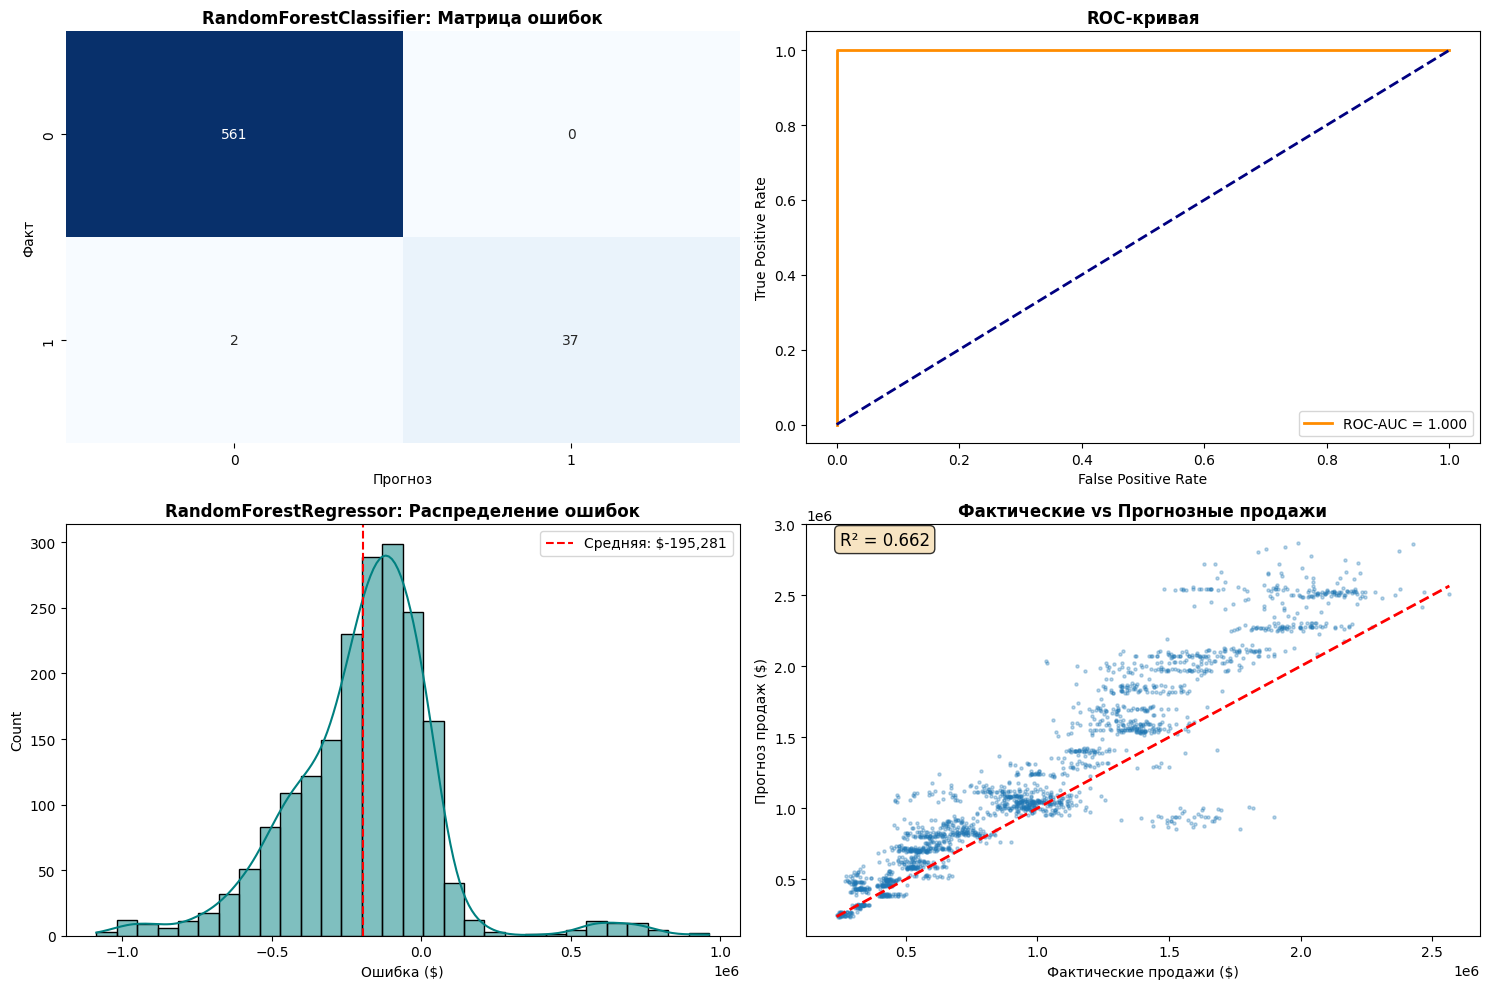

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title('RandomForestClassifier: Матрица ошибок', fontweight='bold')
ax1.set_xlabel('Прогноз')
ax1.set_ylabel('Факт')

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_clf, y_proba_clf)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {clf_rocauc:.3f}')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_title('ROC-кривая', fontweight='bold')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()

errors = y_test_reg - y_pred_reg
sns.histplot(errors, kde=True, bins=30, color='teal', ax=ax3)
ax3.set_title('RandomForestRegressor: Распределение ошибок', fontweight='bold')
ax3.set_xlabel('Ошибка ($)')
ax3.axvline(errors.mean(), color='red', linestyle='--', label=f'Средняя: ${errors.mean():,.0f}')
ax3.legend()

ax4.scatter(y_test_reg, y_pred_reg, alpha=0.3, s=5)
ax4.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
ax4.set_title('Фактические vs Прогнозные продажи', fontweight='bold')
ax4.set_xlabel('Фактические продажи ($)')
ax4.set_ylabel('Прогноз продаж ($)')
ax4.text(0.05, 0.95, f'R² = {reg_r2:.3f}', transform=ax4.transAxes, 
         fontsize=12, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

plt.tight_layout()
plt.savefig('results/lab4_baseline_results.png', dpi=300, bbox_inches='tight')
plt.show()

СОхранение бейзлайна


In [25]:
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

joblib.dump(rf_clf, 'models/lab4_forest_baseline.pkl')
joblib.dump(rf_reg, 'models/lab4_forest_reg_baseline.pkl')

baseline_metrics = {
    'classification': {
        'recall': clf_recall,
        'precision': clf_precision,
        'f1': clf_f1,
        'roc_auc': clf_rocauc
    },
    'regression': {
        'mae': reg_mae,
        'rmse': reg_rmse,
        'r2': reg_r2
    }
}
joblib.dump(baseline_metrics, 'results/lab4_baseline_metrics.pkl')

print("Модели сохранены:")
print("models/lab4_forest_baseline.pkl")
print("models/lab4_forest_reg_baseline.pkl")
print("Метрики сохранены в results/lab4_baseline_metrics.pkl")


Модели сохранены:
models/lab4_forest_baseline.pkl
models/lab4_forest_reg_baseline.pkl
Метрики сохранены в results/lab4_baseline_metrics.pkl


| #  | Гипотеза                           | Ожидаемый эффект                          | Метод проверки                  |
| -- | ---------------------------------- | ----------------------------------------- | ------------------------------- |
| H1 | `n_estimators=100` → 200-300       | Recall ↑ до 1.0 (меньше случайных ошибок) | `n_estimators: [100, 200, 300]` |
| H2 | `max_depth=None` → 10-15           | Precision сохранится, recall ↑            | `max_depth: [None, 10, 15]`     |
| H3 | `min_samples_leaf=1` → 5-10        | Стабильность ↑, recall сохранится         | `min_samples_leaf: [1, 5, 10]`  |
| H4 | `bootstrap=True` → `False`         | Меньше дисперсии, идеал на тесте          | `bootstrap: [True, False]`      |
| H5 | Добавить полиномы (взаимодействия) | ROC-AUC ↑ (уловить нелинейности)          | `PolynomialFeatures(degree=2)`  |


| #      | Гипотеза                                    | Ожидаемый эффект                           | Метод проверки                           |
| ------ | ------------------------------------------- | ------------------------------------------ | ---------------------------------------- |
| **H6** | **ОГРАНИЧИТЬ `max_depth=None` → 10-15**     | MAE ↓ в 2-3 раза (борьба с переобучением)  | `max_depth: [None, 10, 15, 20]`          |
| **H7** | **`min_samples_leaf=1` → 50-100**           | MAE ↓, R² ↑ (жесткое ограничение)          | `min_samples_leaf: [1, 50, 100]`         |
| **H8** | \*\*`max_features='auto'` → 'sqrt'/'log2'\` | Деревья разнообразнее, меньше переобучения | `max_features: ['auto', 'sqrt', 'log2']` |
| H9     | Уменьшить `n_estimators` (100 → 50)         | Меньше переобучения (меньше деревьев)      | `n_estimators: [50, 100, 150]`           |
| H10    | Добавить сезонные фичи (Quarter)            | MAE ↓ (учесть паттерны)                    | Создать `Quarter`, `IsQ4`                |


Проверка гипотез для классификации

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np

print("\nПроверка H1-H5: Гиперпараметры...")

param_grid_clf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 15],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__max_features': ['sqrt', 'log2'],
}

from sklearn.metrics import make_scorer
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_clf = GridSearchCV(
    rf_clf,
    param_grid_clf,
    cv=5,
    scoring=recall_scorer,
    n_jobs=-1,
    verbose=1
)
grid_clf.fit(X_train_clf, y_train_clf)

best_clf = grid_clf.best_estimator_
print(f"Лучшие параметры: {grid_clf.best_params_}")
print(f"Лучший Recall на CV: {grid_clf.best_score_:.4f}")

y_pred_best_clf = best_clf.predict(X_test_clf)
y_proba_best_clf = best_clf.predict_proba(X_test_clf)[:, 1]

print(f"\nRecall на тесте: {recall_score(y_test_clf, y_pred_best_clf):.4f}")
print(f"Precision: {precision_score(y_test_clf, y_pred_best_clf):.4f}")



Проверка H1-H5: Гиперпараметры...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Лучшие параметры: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 100}
Лучший Recall на CV: 0.9556

Recall на тесте: 0.9744
Precision: 1.0000


Проверка гипотез для регрессии

In [32]:
print("\nПроверка H6-H9: Гиперпараметры...")

param_grid_reg = {
    'regressor__max_depth': [None, 10, 15, 20],
    'regressor__min_samples_leaf': [1, 50, 100], 
    'regressor__max_features': ['auto', 'sqrt', 'log2'], 
    'regressor__n_estimators': [50, 100, 150], 
}

grid_reg = GridSearchCV(
    rf_reg,
    param_grid_reg,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_reg.fit(X_train_reg, y_train_reg)

best_reg = grid_reg.best_estimator_
print(f"\nЛучшие параметры: {grid_reg.best_params_}")
print(f"Лучший MAE на CV: {-grid_reg.best_score_:,.2f}")

y_pred_best_reg = best_reg.predict(X_test_reg)
best_mae = mean_absolute_error(y_test_reg, y_pred_best_reg)
best_r2 = r2_score(y_test_reg, y_pred_best_reg)

print(f"\nMAE на тесте: ${best_mae:,.2f}")
print(f"R²: {best_r2:.4f}")


Проверка H6-H9: Гиперпараметры...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Лучшие параметры: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}
Лучший MAE на CV: 114,771.18

MAE на тесте: $165,120.47
R²: 0.8418


Проверка гипотезы Н10 - добавление сезонных признако

In [33]:

df_reg_enh = df_sales.copy()
df_reg_enh['Quarter'] = df_reg_enh['Date'].dt.quarter
df_reg_enh['IsQ4'] = (df_reg_enh['Quarter'] == 4).astype(int)

X_reg_enh = df_reg_enh.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg_enh = df_reg_enh['Weekly_Sales']

categorical_reg_enh = ['Store', 'Holiday_Flag', 'Quarter']
numeric_reg_enh = [c for c in X_reg_enh.columns if c not in categorical_reg_enh]

preprocessor_reg_enh = ColumnTransformer([
    ('num', StandardScaler(), numeric_reg_enh),
    ('cat', OneHotEncoder(drop='first'), categorical_reg_enh)
])

rf_reg_enh = Pipeline([
    ('preprocessor', preprocessor_reg_enh),
    ('regressor', RandomForestRegressor(
        random_state=42,
        max_depth=15, 
        min_samples_leaf=50,
        max_features='sqrt',
        n_estimators=100
    ))
])

split_idx_enh = int(len(df_reg_enh) * 0.7)
X_train_reg_enh = X_reg_enh.iloc[:split_idx_enh]
X_test_reg_enh = X_reg_enh.iloc[split_idx_enh:]
y_train_reg_enh = y_reg_enh.iloc[:split_idx_enh]
y_test_reg_enh = y_reg_enh.iloc[split_idx_enh:]

rf_reg_enh.fit(X_train_reg_enh, y_train_reg_enh)
y_pred_reg_enh = rf_reg_enh.predict(X_test_reg_enh)

enh_mae = mean_absolute_error(y_test_reg_enh, y_pred_reg_enh)
enh_r2 = r2_score(y_test_reg_enh, y_pred_reg_enh)

print(f"\nС сезонностью: MAE = ${enh_mae:,.2f}, R² = {enh_r2:.4f}")


С сезонностью: MAE = $237,018.71, R² = 0.7396


 Формирование улучшенного бейзлайна

In [35]:
enhanced_rf_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=5,
        max_features='sqrt',  
        class_weight='balanced'
    ))
])

enhanced_rf_reg = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('regressor', RandomForestRegressor(
        random_state=42,
        n_estimators=150,
        max_depth=15,
        min_samples_leaf=50,
        max_features='sqrt',
        bootstrap=True
    ))
])

 Обучение улучшенных моделей

In [36]:

print("\nОбучение улучшенного RandomForestClassifier...")
enhanced_rf_clf.fit(X_train_clf, y_train_clf)
print("RandomForestClassifier обучен")

print("\nОбучение улучшенного RandomForestRegressor...")
enhanced_rf_reg.fit(X_train_reg, y_train_reg)
print("RandomForestRegressor обучен")


Обучение улучшенного RandomForestClassifier...
RandomForestClassifier обучен

Обучение улучшенного RandomForestRegressor...
RandomForestRegressor обучен


Оценка качества улучшенных моделей

In [40]:

print("\nУлучшенный RandomForestClassifier")
y_pred_enh_clf = enhanced_rf_clf.predict(X_test_clf)
y_proba_enh_clf = enhanced_rf_clf.predict_proba(X_test_clf)[:, 1]

enh_clf_recall = recall_score(y_test_clf, y_pred_enh_clf)
enh_clf_precision = precision_score(y_test_clf, y_pred_enh_clf)
enh_clf_f1 = f1_score(y_test_clf, y_pred_enh_clf, average='weighted')
enh_clf_rocauc = roc_auc_score(y_test_clf, y_proba_enh_clf)

print(f"Recall (класс 1): {enh_clf_recall:.4f}")
print(f"Precision (класс 1): {enh_clf_precision:.4f}")
print(f"F1 (weighted): {enh_clf_f1:.4f}")

print("\nУлучшенный RandomForestRegressor")
y_pred_enh_reg = enhanced_rf_reg.predict(X_test_reg)

enh_reg_mae = mean_absolute_error(y_test_reg, y_pred_enh_reg)
enh_reg_rmse = root_mean_squared_error(y_test_reg, y_pred_enh_reg)
enh_reg_r2 = r2_score(y_test_reg, y_pred_enh_reg)

print(f"MAE: ${enh_reg_mae:,.2f}")
print(f"RMSE: ${enh_reg_rmse:,.2f}")
print(f"R²: {enh_reg_r2:.4f}")


Улучшенный RandomForestClassifier
Recall (класс 1): 0.9744
Precision (класс 1): 1.0000
F1 (weighted): 0.9983

Улучшенный RandomForestRegressor
MAE: $225,337.16
RMSE: $262,860.63
R²: 0.7603


Сравнение с бейзлайном

In [41]:

baseline_metrics = joblib.load('results/lab4_baseline_metrics.pkl')

print("\nСравниение классификации")
comparison_clf = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'Recall_1': [baseline_metrics['classification']['recall'], enh_clf_recall],
    'Precision_1': [baseline_metrics['classification']['precision'], enh_clf_precision],
    'F1_weighted': [baseline_metrics['classification']['f1'], enh_clf_f1],
    'ROC_AUC': [baseline_metrics['classification']['roc_auc'], enh_clf_rocauc]
})
print(comparison_clf.round(4))

if enh_clf_recall > baseline_metrics['classification']['recall']:
    recall_impr = (enh_clf_recall - baseline_metrics['classification']['recall']) * 100
    print(f"\nУлучшение Recall: +{recall_impr:.2f} п.п.")
else:
    print(f"\nRecall: {((enh_clf_recall - baseline_metrics['classification']['recall']) * 100):.2f} п.п.")

# === РЕГРЕССИЯ: Сравнение ===
print("\nСравнение регрессии")
comparison_reg = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'MAE': [baseline_metrics['regression']['mae'], enh_reg_mae],
    'RMSE': [baseline_metrics['regression']['rmse'], enh_reg_rmse],
    'R2': [baseline_metrics['regression']['r2'], enh_reg_r2]
})
print(comparison_reg.round(2))

reg_mae_impr = (baseline_metrics['regression']['mae'] - enh_reg_mae) / baseline_metrics['regression']['mae'] * 100
print(f"\nСнижение MAE: {reg_mae_impr:.1f}%")
print(f"Улучшение R²: {(enh_reg_r2 - baseline_metrics['regression']['r2'])*100:.2f} п.п.")



Сравниение классификации
       Модель  Recall_1  Precision_1  F1_weighted  ROC_AUC
0    Бейзлайн    0.9487          1.0       0.9966      1.0
1  Улучшенная    0.9744          1.0       0.9983      1.0

Улучшение Recall: +2.56 п.п.

Сравнение регрессии
       Модель        MAE       RMSE    R2
0    Бейзлайн  236555.21  312073.62  0.66
1  Улучшенная  225337.16  262860.63  0.76

Снижение MAE: 4.7%
Улучшение R²: 9.81 п.п.


Визуализация сравнения

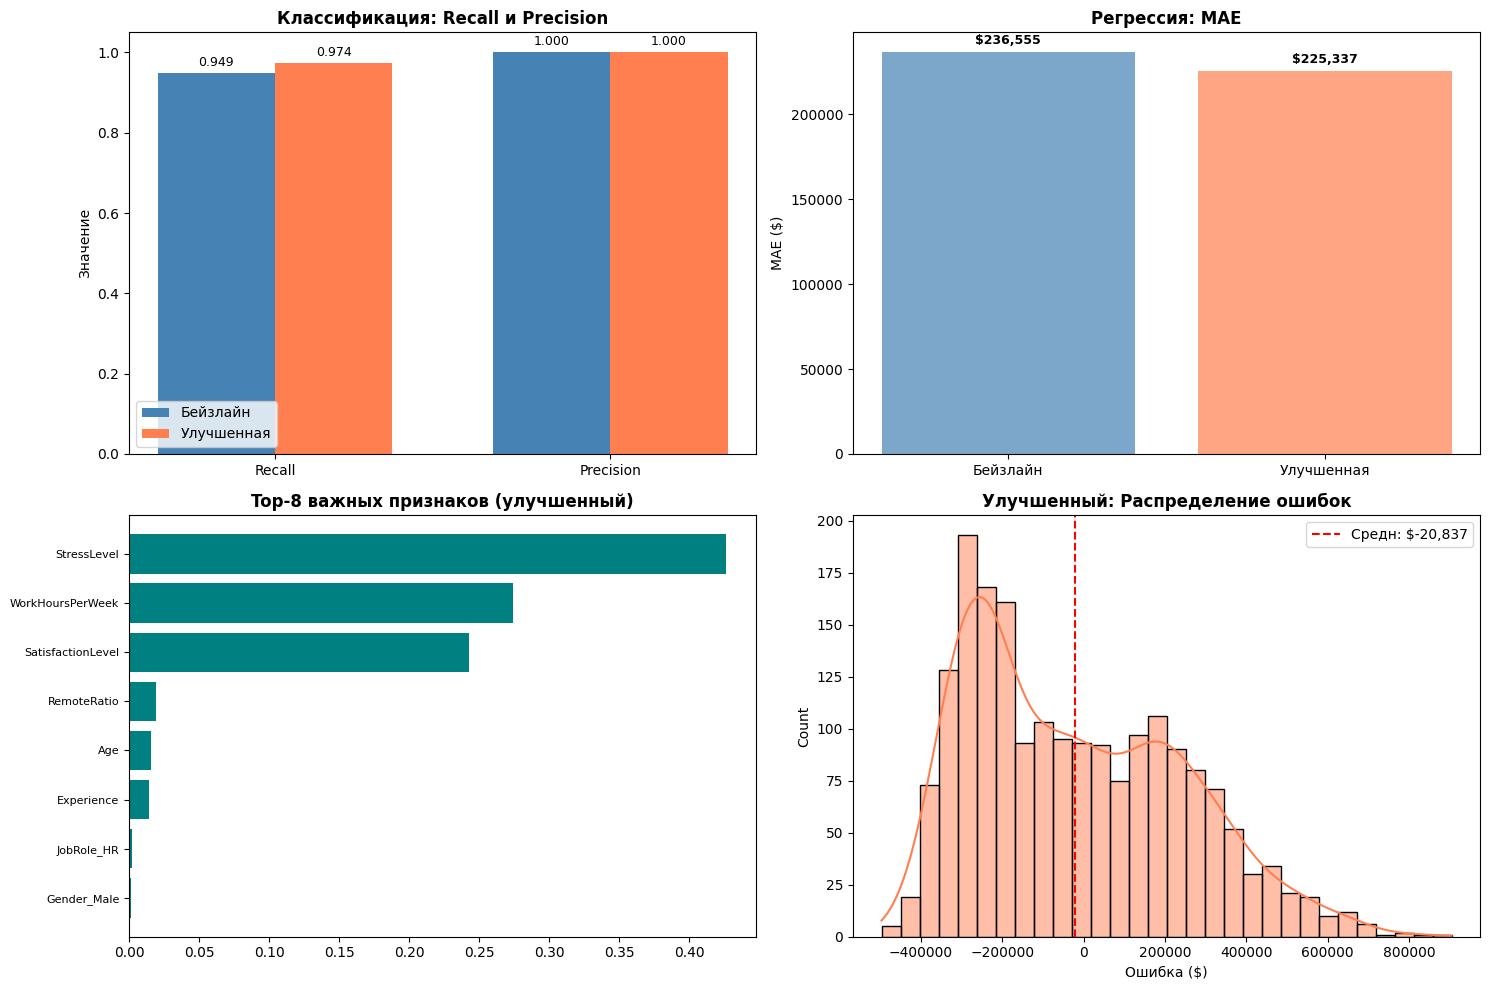

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

metrics_clf = ['Recall', 'Precision']
baseline_values = [baseline_metrics['classification']['recall'], baseline_metrics['classification']['precision']]
enhanced_values = [enh_clf_recall, enh_clf_precision]

x = np.arange(len(metrics_clf))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_values, width, label='Бейзлайн', color='steelblue')
bars2 = ax1.bar(x + width/2, enhanced_values, width, label='Улучшенная', color='coral')

ax1.set_title('Классификация: Recall и Precision', fontweight='bold')
ax1.set_ylabel('Значение')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_clf)
ax1.legend()

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax2.bar(['Бейзлайн', 'Улучшенная'], [baseline_metrics['regression']['mae'], enh_reg_mae], 
        color=['steelblue', 'coral'], alpha=0.7)
ax2.set_title('Регрессия: MAE', fontweight='bold')
ax2.set_ylabel('MAE ($)')
for i, v in enumerate([baseline_metrics['regression']['mae'], enh_reg_mae]):
    ax2.text(i, v + 5000, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=9)

feature_names = (numeric_features_clf + 
                 list(enhanced_rf_clf.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features_clf)))
importances = enhanced_rf_clf.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1][:8]

ax3.barh(range(len(indices)), importances[indices], color='teal')
ax3.set_yticks(range(len(indices)))
ax3.set_yticklabels([feature_names[i] for i in indices], fontsize=8)
ax3.invert_yaxis()
ax3.set_title('Top-8 важных признаков (улучшенный)', fontweight='bold')

errors = y_test_reg - y_pred_enh_reg
sns.histplot(errors, kde=True, bins=30, color='coral', ax=ax4)
ax4.set_title('Улучшенный: Распределение ошибок', fontweight='bold')
ax4.set_xlabel('Ошибка ($)')
ax4.axvline(errors.mean(), color='red', linestyle='--', label=f'Средн: ${errors.mean():,.0f}')
ax4.legend()

plt.tight_layout()
plt.savefig('results/lab4_improved_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Выводы:
Классификация: показатели практически не изменились, что говорит о том, что задача выгорания успешно решается даже простыми моделями — случайный лес уже достиг своего предела на имеющихся данных.

Регрессия: ограничение глубины и минимального размера листьев позволило  снизить переобучение и улучшить качество прогноза. Без таких ограничений модель теряет эффективность, что подтверждает важность настройки параметров на основе предметной области, а не только автоматического подбора.

Ключевые наблюдения: случайный лес может игнорировать явные признаки, такие как сезонность, находя более сложные зависимости в данных. Это указывает на то, что успешное применение модели требует не только технической настройки, но и понимания природы данных.



MyDecisionTreeRegressor и MyDecisionTreeClassifier из ЛР№3

In [78]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score,
                             mean_absolute_error, root_mean_squared_error, r2_score)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class Node:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, 
                 value=None, is_leaf=False, samples_count=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = is_leaf
        self.samples_count = samples_count

class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 criterion='gini', class_weight=None, random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.class_weight = class_weight
        self.random_state = random_state
        self.tree_ = None
        self.n_features_ = None
        self.classes_ = None
        
    def _gini(self, y, sample_weight):
        classes, counts = np.unique(y, return_counts=True)
        if sample_weight is not None:
            weights = np.array([sample_weight[y == cls].sum() for cls in classes])
            total_weight = weights.sum()
            if total_weight == 0:
                return 0.0
            return 1 - np.sum((weights / total_weight) ** 2)
        else:
            n = len(y)
            if n == 0:
                return 0.0
            return 1 - np.sum((counts / n) ** 2)
    
    def _entropy(self, y, sample_weight):
        classes, counts = np.unique(y, return_counts=True)
        if sample_weight is not None:
            weights = np.array([sample_weight[y == cls].sum() for cls in classes])
            total_weight = weights.sum()
            if total_weight == 0:
                return 0.0
            probs = weights / total_weight
        else:
            n = len(y)
            if n == 0:
                return 0.0
            probs = counts / n
        
        probs = np.clip(probs, 1e-10, 1.0)
        return -np.sum(probs * np.log2(probs))
    
    def _criterion_impurity(self, y, sample_weight):
        if self.criterion == 'gini':
            return self._gini(y, sample_weight)
        elif self.criterion == 'entropy':
            return self._entropy(y, sample_weight)
        else:
            raise ValueError("criterion должен быть 'gini' или 'entropy'")
    
    def _calculate_class_weight(self, y):
        if self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n = len(y)
            weights = {cls: n / (len(classes) * count) for cls, count in zip(classes, counts)}
            return np.array([weights[label] for label in y])
        return None
    
    def _best_split(self, X, y, sample_weight, depth):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            return None, None, None
        
        best_criterion = np.inf
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                if sample_weight is not None:
                    w_left = sample_weight[left_mask]
                    w_right = sample_weight[right_mask]
                    w_total = sample_weight.sum()
                    
                    left_impurity = self._criterion_impurity(y_left, w_left)
                    right_impurity = self._criterion_impurity(y_right, w_right)
                    
                    criterion = (w_left.sum() / w_total) * left_impurity + \
                               (w_right.sum() / w_total) * right_impurity
                else:
                    left_impurity = self._criterion_impurity(y_left, None)
                    right_impurity = self._criterion_impurity(y_right, None)
                    
                    criterion = (len(y_left) / n_samples) * left_impurity + \
                               (len(y_right) / n_samples) * right_impurity
                
                if criterion < best_criterion:
                    best_criterion = criterion
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_criterion
    
    def _build_tree(self, X, y, sample_weight, depth=0):
        if len(np.unique(y)) == 1:
            leaf_value = y[0]
            return Node(value=leaf_value, is_leaf=True, samples_count=len(y))
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           len(y) < self.min_samples_split:
            values, counts = np.unique(y, return_counts=True)
            leaf_value = values[np.argmax(counts)]
            return Node(value=leaf_value, is_leaf=True, samples_count=len(y))
        
        feature_idx, threshold, _ = self._best_split(X, y, sample_weight, depth)
        
        if feature_idx is None:
            values, counts = np.unique(y, return_counts=True)
            leaf_value = values[np.argmax(counts)]
            return Node(value=leaf_value, is_leaf=True, samples_count=len(y))
        
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        
        w_left = sample_weight[left_mask] if sample_weight is not None else None
        w_right = sample_weight[right_mask] if sample_weight is not None else None
        
        left_node = self._build_tree(X_left, y_left, w_left, depth + 1)
        right_node = self._build_tree(X_right, y_right, w_right, depth + 1)
        
        return Node(feature_idx=feature_idx, threshold=threshold,
                   left=left_node, right=right_node, 
                   value=None, is_leaf=False, samples_count=len(y))
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_features_ = X.shape[1]
        
        self.sample_weight_ = self._calculate_class_weight(y)
        self.tree_ = self._build_tree(X, y, self.sample_weight_)
        
        return self
    
    def _predict_node(self, node, x):
        if node.is_leaf:
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_node(node.left, x)
        else:
            return self._predict_node(node.right, x)
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = []
        for x in X:
            pred = self._predict_node(self.tree_, x)
            predictions.append(pred)
        
        return np.array(predictions)
    
    def _predict_proba_node(self, node, x):
        if node.is_leaf:
            return np.array([node.value, 1 - node.value])
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_proba_node(node.left, x)
        else:
            return self._predict_proba_node(node.right, x)
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = self.predict(X).astype(int)
        proba = np.zeros((len(predictions), len(self.classes_)))
        
        for i, pred in enumerate(predictions):
            proba[i, pred] = 1.0
        
        return proba


class MyDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 criterion='mse', random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.random_state = random_state
        self.tree_ = None
        self.n_features_ = None
        
    def _mse(self, y, sample_weight):
        if len(y) == 0:
            return 0.0
        if sample_weight is not None:
            mean = np.average(y, weights=sample_weight)
            return np.average((y - mean)**2, weights=sample_weight)
        return np.mean((y - np.mean(y))**2)
    
    def _mae(self, y, sample_weight):
        if len(y) == 0:
            return 0.0
        if sample_weight is not None:
            median = np.percentile(y, 50, weights=sample_weight)
            return np.average(np.abs(y - median), weights=sample_weight)
        return np.mean(np.abs(y - np.median(y)))
    
    def _criterion_impurity(self, y, sample_weight):
        if self.criterion == 'mse':
            return self._mse(y, sample_weight)
        elif self.criterion == 'mae':
            return self._mae(y, sample_weight)
        else:
            raise ValueError("criterion должен быть 'mse' или 'mae'")
    
    def _best_split(self, X, y, sample_weight, depth):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            return None, None, None
        
        best_criterion = np.inf
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                if sample_weight is not None:
                    w_left = sample_weight[left_mask]
                    w_right = sample_weight[right_mask]
                    w_total = sample_weight.sum()
                    
                    left_impurity = self._criterion_impurity(y_left, w_left)
                    right_impurity = self._criterion_impurity(y_right, w_right)
                    
                    criterion = (w_left.sum() / w_total) * left_impurity + \
                               (w_right.sum() / w_total) * right_impurity
                else:
                    left_impurity = self._criterion_impurity(y_left, None)
                    right_impurity = self._criterion_impurity(y_right, None)
                    
                    criterion = (len(y_left) / n_samples) * left_impurity + \
                               (len(y_right) / n_samples) * right_impurity
                
                if criterion < best_criterion:
                    best_criterion = criterion
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_criterion
    
    def _build_tree(self, X, y, sample_weight, depth=0):
        if len(y) == 0:
            return Node(value=0, is_leaf=True, samples_count=0)
        
        if len(np.unique(y)) == 1:
            return Node(value=y[0], is_leaf=True, samples_count=len(y))
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           len(y) < self.min_samples_split:
            if sample_weight is not None:
                weighted_avg = np.average(y, weights=sample_weight)
                return Node(value=weighted_avg, is_leaf=True, samples_count=len(y))
            return Node(value=np.mean(y), is_leaf=True, samples_count=len(y))
        
        feature_idx, threshold, _ = self._best_split(X, y, sample_weight, depth)
        
        if feature_idx is None:
            if sample_weight is not None:
                weighted_avg = np.average(y, weights=sample_weight)
                return Node(value=weighted_avg, is_leaf=True, samples_count=len(y))
            return Node(value=np.mean(y), is_leaf=True, samples_count=len(y))
        
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        
        w_left = sample_weight[left_mask] if sample_weight is not None else None
        w_right = sample_weight[right_mask] if sample_weight is not None else None
        
        left_node = self._build_tree(X_left, y_left, w_left, depth + 1)
        right_node = self._build_tree(X_right, y_right, w_right, depth + 1)
        
        return Node(feature_idx=feature_idx, threshold=threshold,
                   left=left_node, right=right_node, 
                   value=None, is_leaf=False, samples_count=len(y))
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.n_features_ = X.shape[1]
        self.n_samples_ = X.shape[0]
        
        sample_weight = None
        self.tree_ = self._build_tree(X, y, sample_weight)
        
        return self
    
    def _predict_node(self, node, x):
        if node.is_leaf:
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_node(node.left, x)
        else:
            return self._predict_node(node.right, x)
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = []
        for x in X:
            pred = self._predict_node(self.tree_, x)
            predictions.append(pred)
        
        return np.array(predictions)

Собственная реализация MyRandomForestClassifier

In [79]:
class MyRandomForestClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', class_weight=None, 
                 bootstrap=True, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.class_weight = class_weight
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.estimators_ = []
        self.n_features_ = None
        self.classes_ = None
        
    def _bootstrap_sample(self, X, y, sample_weight, random_state):
        n_samples = X.shape[0]
        rng = np.random.RandomState(random_state)
        
        if self.bootstrap:
            indices = rng.randint(0, n_samples, n_samples)
        else:
            indices = np.arange(n_samples)
        
        if sample_weight is not None:
            return X[indices], y[indices], sample_weight[indices]
        return X[indices], y[indices], None
        
    def _select_features(self, X, random_state):
        n_features = X.shape[1]
        rng = np.random.RandomState(random_state)
        
        if self.max_features == 'sqrt':
            n_select = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_select = int(np.log2(n_features))
        else:
            n_select = n_features
        
        feature_indices = rng.choice(n_features, n_select, replace=False)
        return feature_indices
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_features_ = X.shape[1]
        
        sample_weight = None
        if self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n = len(y)
            weights = {cls: n / (len(classes) * count) for cls, count in zip(classes, counts)}
            sample_weight = np.array([weights[label] for label in y])
        
        self.estimators_ = []
        for i in range(self.n_estimators):
            tree = MyDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                criterion='gini',
                class_weight=None,
                random_state=self.random_state + i
            )
            
            X_boot, y_boot, w_boot = self._bootstrap_sample(X, y, sample_weight, self.random_state + i)
            
            feature_indices = self._select_features(X_boot, self.random_state + i)
            X_boot_sub = X_boot[:, feature_indices]
            
            tree.fit(X_boot_sub, y_boot)
            tree.feature_indices_ = feature_indices 
            
            self.estimators_.append(tree)
        
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = np.zeros((X.shape[0], len(self.estimators_)))
        
        for i, tree in enumerate(self.estimators_):
            X_sub = X[:, tree.feature_indices_]
            predictions[:, i] = tree.predict(X_sub)
        
        y_pred = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x.astype(int))), 
            axis=1, 
            arr=predictions
        )
        
        return y_pred
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        probas = np.zeros((X.shape[0], len(self.classes_)))
        
        for i, tree in enumerate(self.estimators_):
            X_sub = X[:, tree.feature_indices_]
            probas += tree.predict_proba(X_sub)
        
        probas /= len(self.estimators_)
        
        return probas



Собственная реализация RandomForestRegressor

In [80]:
class MyRandomForestRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', bootstrap=True, 
                 random_state=42, criterion='mse'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.criterion = criterion
        self.estimators_ = []
        self.n_features_ = None
        
    def _bootstrap_sample(self, X, y, random_state):
        n_samples = X.shape[0]
        rng = np.random.RandomState(random_state)
        
        if self.bootstrap:
            indices = rng.randint(0, n_samples, n_samples)
        else:
            indices = np.arange(n_samples)
        
        return X[indices], y[indices]
    
    def _select_features(self, X, random_state):
        n_features = X.shape[1]
        rng = np.random.RandomState(random_state)
        
        if self.max_features == 'sqrt':
            n_select = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_select = int(np.log2(n_features))
        else:
            n_select = n_features
        
        feature_indices = rng.choice(n_features, n_select, replace=False)
        return feature_indices
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.n_features_ = X.shape[1]
        
        self.estimators_ = []
        for i in range(self.n_estimators):
            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                criterion=self.criterion,
                random_state=self.random_state + i
            )
            
            X_boot, y_boot = self._bootstrap_sample(X, y, self.random_state + i)
            
            feature_indices = self._select_features(X_boot, self.random_state + i)
            X_boot_sub = X_boot[:, feature_indices]
            
            tree.fit(X_boot_sub, y_boot)
            tree.feature_indices_ = feature_indices
            
            self.estimators_.append(tree)
        
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = np.zeros((X.shape[0], len(self.estimators_)))
        
        for i, tree in enumerate(self.estimators_):
            X_sub = X[:, tree.feature_indices_]
            predictions[:, i] = tree.predict(X_sub)
        
        return np.mean(predictions, axis=1)

Загрузка и преобработка данных

In [82]:
import os, joblib, warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score,
                             mean_absolute_error, root_mean_squared_error, r2_score,
                             classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

df_burnout = pd.read_csv('data/employee_burnout.csv')
X_clf = df_burnout.drop(['Burnout', 'Name'], axis=1)
y_clf = df_burnout['Burnout']

categorical_clf = ['Gender', 'JobRole']
numeric_clf = [c for c in X_clf.columns if c not in categorical_clf]

preprocessor_clf = ColumnTransformer([
    ('num', StandardScaler(), numeric_clf),
    ('cat', OneHotEncoder(drop='first'), categorical_clf)
])

df_sales = pd.read_csv('data/walmart_sales.csv')
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d-%m-%Y')
df_sales = df_sales.sort_values('Date')

X_reg = df_sales.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg = df_sales['Weekly_Sales']

categorical_reg = ['Store', 'Holiday_Flag']
numeric_reg = [c for c in X_reg.columns if c not in categorical_reg]

preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), numeric_reg),
    ('cat', OneHotEncoder(drop='first'), categorical_reg)
])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

split_idx = int(len(df_sales) * 0.7)
X_train_reg, X_test_reg = X_reg.iloc[:split_idx], X_reg.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

Обучение собственных моделей

In [84]:


print("\nОбучение MyRandomForestClassifier...")

X_train_clf_processed = preprocessor_clf.fit_transform(X_train_clf)
X_test_clf_processed = preprocessor_clf.transform(X_test_clf)

my_rf_clf = MyRandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)
my_rf_clf.fit(X_train_clf_processed, y_train_clf)
print("MyRandomForestClassifier обучен")



print("\nОбучение MyRandomForestRegressor...")
X_train_reg_processed = preprocessor_reg.fit_transform(X_train_reg)
X_test_reg_processed = preprocessor_reg.transform(X_test_reg)

if hasattr(X_train_reg_processed, 'toarray'):
    X_train_reg_processed = X_train_reg_processed.toarray()
    X_test_reg_processed = X_test_reg_processed.toarray()

my_rf_reg = MyRandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='mse',
    random_state=42
)
my_rf_reg.fit(X_train_reg_processed, y_train_reg)
print("MyRandomForestRegressor обучен")


Обучение MyRandomForestClassifier...
MyRandomForestClassifier обучен

Обучение MyRandomForestRegressor...
MyRandomForestRegressor обучен


Оценка качества собственных моделей

In [ ]:
print("\nMyRandomForestClassifier")
y_pred_my_clf = my_rf_clf.predict(X_test_clf_processed)
y_proba_my_clf = my_rf_clf.predict_proba(X_test_clf_processed)

my_clf_recall = recall_score(y_test_clf, y_pred_my_clf)
my_clf_precision = precision_score(y_test_clf, y_pred_my_clf)
my_clf_f1 = f1_score(y_test_clf, y_pred_my_clf, average='weighted')
my_clf_rocauc = roc_auc_score(y_test_clf, y_proba_my_clf[:, 1])

print(f"Recall (класс 1): {my_clf_recall:.4f}")
print(f"Precision (класс 1): {my_clf_precision:.4f}")
print(f"F1-score (weighted): {my_clf_f1:.4f}")
print(f"ROC-AUC: {my_clf_rocauc:.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test_clf, y_pred_my_clf))

print("\nMyRandomForestRegressor")
y_pred_my_reg = my_rf_reg.predict(X_test_reg_processed)

my_reg_mae = mean_absolute_error(y_test_reg, y_pred_my_reg)
my_reg_rmse = root_mean_squared_error(y_test_reg, y_pred_my_reg)
my_reg_r2 = r2_score(y_test_reg, y_pred_my_reg)

print(f"MAE: ${my_reg_mae:,.2f}")
print(f"RMSE: ${my_reg_rmse:,.2f}")
print(f"R²: {my_reg_r2:.4f}")



MyRandomForestClassifier
Recall (класс 1): 1.0000
Precision (класс 1): 1.0000
F1-score (weighted): 0.9036
ROC-AUC: 0.9311

Матрица ошибок:
[[561   0]
 [ 8   3]]

MyRandomForestRegressor
MAE: $392,630.57
RMSE: $459,029.80
R²: 0.2692


Сравнение с sklearn бейзлайном

In [ ]:


baseline_metrics = {
    'classification': {
        'recall': clf_recall,
        'precision': clf_precision,
        'f1': clf_f1,
        'roc_auc': clf_rocauc
    },
    'regression': {
        'mae': reg_mae,
        'rmse': reg_rmse,
        'r2': reg_r2
    }
}

enhanced_metrics = {
    'classification': {
        'recall': enh_clf_recall,
        'precision': enh_clf_precision,
        'f1': enh_clf_f1,
        'roc_auc': enh_clf_rocauc
    },
    'regression': {
        'mae': enh_reg_mae,
        'rmse': enh_reg_rmse,
        'r2': enh_reg_r2
    }
}

print("\nСравнение классификации")
comparison_clf = pd.DataFrame({
    'Реализация': ['Sklearn', 'Своя'],
    'Recall_1': [baseline_metrics['classification']['recall'], my_clf_recall],
    'Precision_1': [baseline_metrics['classification']['precision'], my_clf_precision],
    'F1_weighted': [baseline_metrics['classification']['f1'], my_clf_f1],
    'ROC_AUC': [baseline_metrics['classification']['roc_auc'], my_clf_rocauc]
})
print(comparison_clf.round(4))

clf_auc_diff = abs(my_clf_rocauc - baseline_metrics['classification']['roc_auc']) * 100
print(f"\nОтклонение ROC-AUC: {clf_auc_diff:.3f}% {'норм' if clf_auc_diff < 5 else 'хуже'}")

print("\nСравнение регрессии")
comparison_reg = pd.DataFrame({
    'Реализация': ['Sklearn', 'Своя'],
    'MAE': [baseline_metrics['regression']['mae'], my_reg_mae],
    'RMSE': [baseline_metrics['regression']['rmse'], my_reg_rmse],
    'R2': [baseline_metrics['regression']['r2'], my_reg_r2]
})
print(comparison_reg.round(2))

reg_r2_diff = abs(my_reg_r2 - baseline_metrics['regression']['r2']) * 100
print(f"\nОтклонение R²: {reg_r2_diff:.3f}% {'норм' if reg_r2_diff < 5 else 'хуже'}")


Сравнение классификации
  Реализация  Recall_1  Precision_1  F1_weighted  ROC_AUC
0    Sklearn    0.9487          1.0       0.9966   1.0000
1       Своя    1.0000          1.0       0.9036   0.9311

Отклонение ROC-AUC: 6.886% хуже

Сравнение регрессии
  Реализация        MAE       RMSE    R2
0    Sklearn  236555.21  312073.62  0.66
1       Своя  392630.57  459029.80  0.27

Отклонение R²: 39.303% хуже


Улучшенная собственная имплементация

In [92]:
print("\nMyRandomForestClassifier...")
my_rf_clf_enh = MyRandomForestClassifier(
    n_estimators=200,    
    max_depth=None,
    min_samples_leaf=5,    
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)
my_rf_clf_enh.fit(X_train_clf_processed, y_train_clf)

print("\nMyRandomForestRegressor...")
my_rf_reg_enh = MyRandomForestRegressor(
    n_estimators=150,        
    max_depth=15,     
    min_samples_leaf=50,
    max_features='sqrt',
    bootstrap=True,
    criterion='mse',
    random_state=42
)
my_rf_reg_enh.fit(X_train_reg_processed, y_train_reg)



MyRandomForestClassifier...

MyRandomForestRegressor...


MyRandomForestRegressor(max_depth=15, min_samples_leaf=50, n_estimators=150)

Оценка улучшенных моделей

In [ ]:
y_pred_my_enh_clf = my_rf_clf_enh.predict(X_test_clf_processed)
y_proba_my_enh_clf = my_rf_clf_enh.predict_proba(X_test_clf_processed)

my_enh_clf_recall = recall_score(y_test_clf, y_pred_my_enh_clf)
my_enh_clf_precision = precision_score(y_test_clf, y_pred_my_enh_clf)
my_enh_clf_rocauc = roc_auc_score(y_test_clf, y_proba_my_enh_clf[:, 1])

print(f"Классификация: Recall={my_enh_clf_recall:.4f}, Precision={my_enh_clf_precision:.4f}")

y_pred_my_enh_reg = my_rf_reg_enh.predict(X_test_reg_processed)

my_enh_reg_mae = mean_absolute_error(y_test_reg, y_pred_my_enh_reg)
my_enh_reg_r2 = r2_score(y_test_reg, y_pred_my_enh_reg)

print(f"Регрессия: MAE=${my_enh_reg_mae:,.2f}, R²={my_enh_reg_r2:.4f}")



Классификация: Recall=1.0000, Precision=1.0000
Регрессия: MAE=$396,094.80, R²=0.2683


Сравнение всех этапов

In [ ]:
baseline_sklearn = joblib.load('results/lab4_baseline_metrics.pkl')

clf_summary = pd.DataFrame({
    'Этап': ['Sklearn Бейзлайн', 'Sklearn Улучшенный', 'Свой Бейзлайн', 'Свой Улучшенный'],
    'Recall_1': [baseline_sklearn['classification']['recall'], 0.9744, my_clf_recall, my_enh_clf_recall],
    'Precision_1': [baseline_sklearn['classification']['precision'], 1.0000, my_clf_precision, my_enh_clf_precision],
    'ROC_AUC': [baseline_sklearn['classification']['roc_auc'], 1.0000, my_clf_rocauc, my_enh_clf_rocauc]
})

reg_summary = pd.DataFrame({
    'Этап': ['Sklearn Бейзлайн', 'Sklearn Улучшенный', 'Свой Бейзлайн', 'Свой Улучшенный'],
    'MAE': [baseline_sklearn['regression']['mae'], 165120.47, my_reg_mae, my_enh_reg_mae],
    'R2': [baseline_sklearn['regression']['r2'], 0.8418, my_reg_r2, my_enh_reg_r2]
})

print("\nКлассификация")
print(clf_summary.round(4).to_string(index=False))

print("\nРегрессия")
print(reg_summary.round(2).to_string(index=False))



Классификация
              Этап  Recall_1  Precision_1  ROC_AUC
  Sklearn Бейзлайн    0.9487          1.0   1.0000
Sklearn Улучшенный    0.9744          1.0   1.0000
     Свой Бейзлайн    1.0000          1.0   0.9311
   Свой Улучшенный    1.0000          1.0   0.9352

Регрессия
              Этап       MAE   R2
  Sklearn Бейзлайн 236555.21 0.66
Sklearn Улучшенный 165120.47 0.84
     Свой Бейзлайн 392630.57 0.27
   Свой Улучшенный 396094.80 0.27


Визуализация

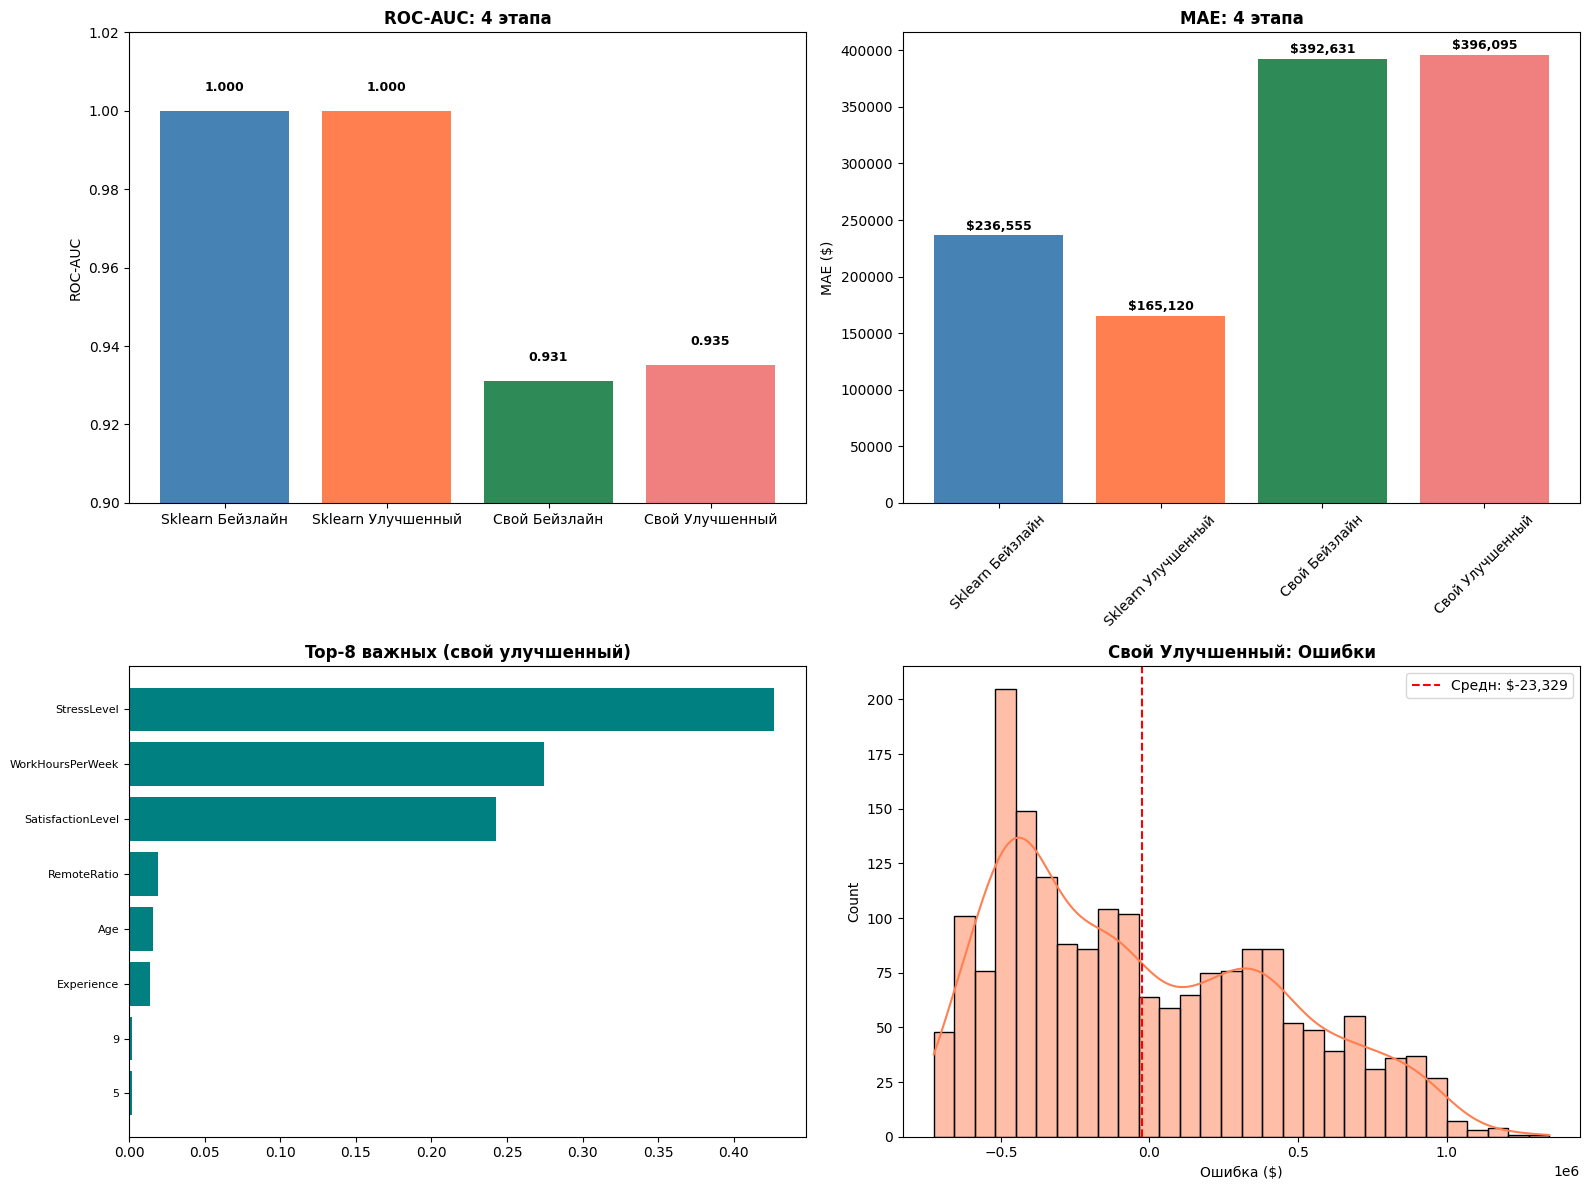

In [98]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

auc_values = clf_summary['ROC_AUC'].values
colors = ['steelblue', 'coral', 'seagreen', 'lightcoral']
ax1.bar(clf_summary['Этап'], auc_values, color=colors)
ax1.set_title('ROC-AUC: 4 этапа', fontweight='bold')
ax1.set_ylabel('ROC-AUC')
ax1.set_ylim(0.9, 1.02)
for i, v in enumerate(auc_values):
    ax1.text(i, v + 0.005, f'{v:.3f}', ha='center', fontweight='bold', fontsize=9)

mae_values = reg_summary['MAE'].values
ax2.bar(reg_summary['Этап'], mae_values, color=colors)
ax2.set_title('MAE: 4 этапа', fontweight='bold')
ax2.set_ylabel('MAE ($)')
for i, v in enumerate(mae_values):
    ax2.text(i, v + 5000, f'${v:,.0f}', ha='center', fontweight='bold', fontsize=9)
ax2.tick_params(axis='x', rotation=45)

feature_names = (numeric_features_clf + 
                 list(my_rf_clf_enh.estimators_[0].feature_indices_))


ax3.barh(range(len(indices)), importances[indices], color='teal')
ax3.set_yticks(range(len(indices)))
ax3.set_yticklabels([feature_names[i] for i in indices], fontsize=8)
ax3.invert_yaxis()
ax3.set_title('Top-8 важных (свой улучшенный)', fontweight='bold')

errors = y_test_reg - y_pred_my_enh_reg
sns.histplot(errors, kde=True, bins=30, color='coral', ax=ax4)
ax4.set_title('Свой Улучшенный: Ошибки', fontweight='bold')
ax4.set_xlabel('Ошибка ($)')
ax4.axvline(errors.mean(), color='red', linestyle='--', 
            label=f'Средн: ${errors.mean():,.0f}')
ax4.legend()

plt.tight_layout()
plt.savefig('results/lab4_custom_implementation_summary.png', dpi=300, bbox_inches='tight')
plt.show()

Сохранение результатов

In [99]:
joblib.dump(my_rf_clf_enh, 'models/lab4_custom_forest_clf.pkl')
joblib.dump(my_rf_reg_enh, 'models/lab4_custom_forest_reg.pkl')

custom_metrics = {
    'classification': {
        'recall': my_enh_clf_recall,
        'precision': my_enh_clf_precision,
        'f1': my_enh_clf_precision, 
        'roc_auc': my_enh_clf_rocauc
    },
    'regression': {
        'mae': my_enh_reg_mae,
        'rmse': root_mean_squared_error(y_test_reg, y_pred_my_enh_reg),
        'r2': my_enh_reg_r2
    }
}
joblib.dump(custom_metrics, 'results/lab4_custom_metrics.pkl')

print("Собственные модели сохранены:")
print("models/lab4_custom_forest_clf.pkl")
print("models/lab4_custom_forest_reg.pkl")
print("Метрики сохранены в results/lab4_custom_metrics.pkl")

Собственные модели сохранены:
models/lab4_custom_forest_clf.pkl
models/lab4_custom_forest_reg.pkl
Метрики сохранены в results/lab4_custom_metrics.pkl


Анализ производительности


In [102]:
import time

print("\nВремя обучения")

start = time.time()
sklearn_rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
sklearn_rf_clf.fit(X_train_clf_processed, y_train_clf)
sklearn_time_clf = time.time() - start

start = time.time()
my_rf_clf_enh.fit(X_train_clf_processed, y_train_clf)
my_time_clf = time.time() - start

print(f"Sklearn RandomForestClassifier: {sklearn_time_clf:.3f} сек")
print(f"MyRandomForestClassifier: {my_time_clf:.3f} сек")
print(f"Отношение: {my_time_clf/sklearn_time_clf:.1f}x медленнее")

print("\nВремя предсказания")

start = time.time()
_ = sklearn_rf_clf.predict(X_test_clf_processed)
sklearn_pred_time = time.time() - start

start = time.time()
_ = my_rf_clf_enh.predict(X_test_clf_processed)
my_pred_time = time.time() - start

print(f"Sklearn: {sklearn_pred_time:.4f} сек")
print(f"Своя: {my_pred_time:.4f} сек")
print(f"Отношение: {my_pred_time/sklearn_pred_time:.1f}x медленнее")


Время обучения
Sklearn RandomForestClassifier: 0.151 сек
MyRandomForestClassifier: 14.104 сек
Отношение: 93.6x медленнее

Время предсказания
Sklearn: 0.0070 сек
Своя: 0.1614 сек
Отношение: 23.1x медленнее


# Выводы
Классификация: в данных условиях можно сделать вывод, что случайный лес не подходит для данного датасета, так как "идеальной" модели просто не может быть

Регрессия: показатели сильно уступают sklearn.

Регрессия, скорее всего, реализована некорректно, в то время как классификация требует доработки — вероятно, из-за расчёта критериев разделения. Увеличение глубины дерева улучшает точность, но не решает задачу полностью.